In [26]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, f1_score
from bicycle.model import BICYCLE
from pathlib import Path
import matplotlib.pyplot as plt
from bicycle.utils.mask_utils import get_sparsity, above_threshold, normalize_matrix

In [68]:
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
ckpts = dict()
include = np.arange(34, 40)
experiment = "noisefactor"
param_of_interest = "grn_noise_p"

for path in models_path.iterdir():
    if int(path.name[-5:]) not in include:
          continue
    ckpt_path = path / "customcheckpoint/last.ckpt"

    if not ckpt_path.exists():
        continue
    print(path.name)
    model = BICYCLE.load_from_checkpoint(ckpt_path).cpu()

    ckpts[str(path.name)] = {}
    with torch.no_grad():
        grn = model.gt_beta.copy()
        ckpts[str(path.name)]["grn"] = grn
        if not model.mask is None:
            beta = np.zeros(grn.shape)
            beta[model.mask.cpu().to(bool)] = model.beta_val
            ckpts[str(path.name)]["beta"] = beta
            #plt.hist(beta)
            #plt.show()

        else:
            ckpts[str(path.name)]["beta"] = model.beta.detach().numpy().copy()
        if not model.bayes_prior is None:
            ckpts[str(path.name)]["prior"] = model.bayes_prior.cpu().numpy().copy()


test_run_00035
Initializing parameters from data
test_run_00038
Initializing parameters from data
test_run_00036
Initializing parameters from data
test_run_00039
Initializing parameters from data
test_run_00034
Initializing parameters from data
test_run_00037
Initializing parameters from data


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.0.9
  rank_zero_warn(


In [67]:
for ckpt in ckpts.values():
    print(type(ckpt))
    if type(ckpt) == dict:
        for val in ckpt.values():
            print(type(val))

<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [79]:
# get environment

plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
columns = [
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "use_hard_mask",
    "masking_mode"
    ]
if not param_of_interest in columns:
    columns.append(param_of_interest)
params = pd.DataFrame(columns=columns)
for dir in plot_path.iterdir():
    if int(dir.name[-5:]) not in include:
          continue
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
params = params.sort_index()
if experiment == "scalemask":
     params = pd.read_csv(models_path.parent/"param1.csv", index_col=0).sort_values("scale_mask")
#params1 = pd.read_csv(models_path.parent/"manual_params.csv", index_col=0).sort_index()
#add = "test_run_00025"
#available_paras=[n for n in params.columns if n in params1.columns]
#params.loc[add, available_paras] = params1.loc[add,available_paras]

In [49]:
params

,pretraining_time,training_time,compile,trad_loading,n_epochs,masking_mode,grn_noise_p
test_run_00034,2112.089337825775,23040.967408180237,True,True,10000,loss,0.0
test_run_00035,2128.6946001052856,21942.318824768066,True,True,10000,loss,0.0010743801652892562
test_run_00036,2258.169945716858,21996.59038043022,True,True,10000,loss,0.0026859504132231405
test_run_00037,2207.0780968666077,21667.777346134186,True,True,10000,loss,0.005371900826446281
test_run_00038,2285.7601590156555,22636.64414167404,True,True,10000,loss,0.010743801652892562
test_run_00039,2243.176301717758,22954.54628443718,True,True,10000,loss,0.021487603305785124


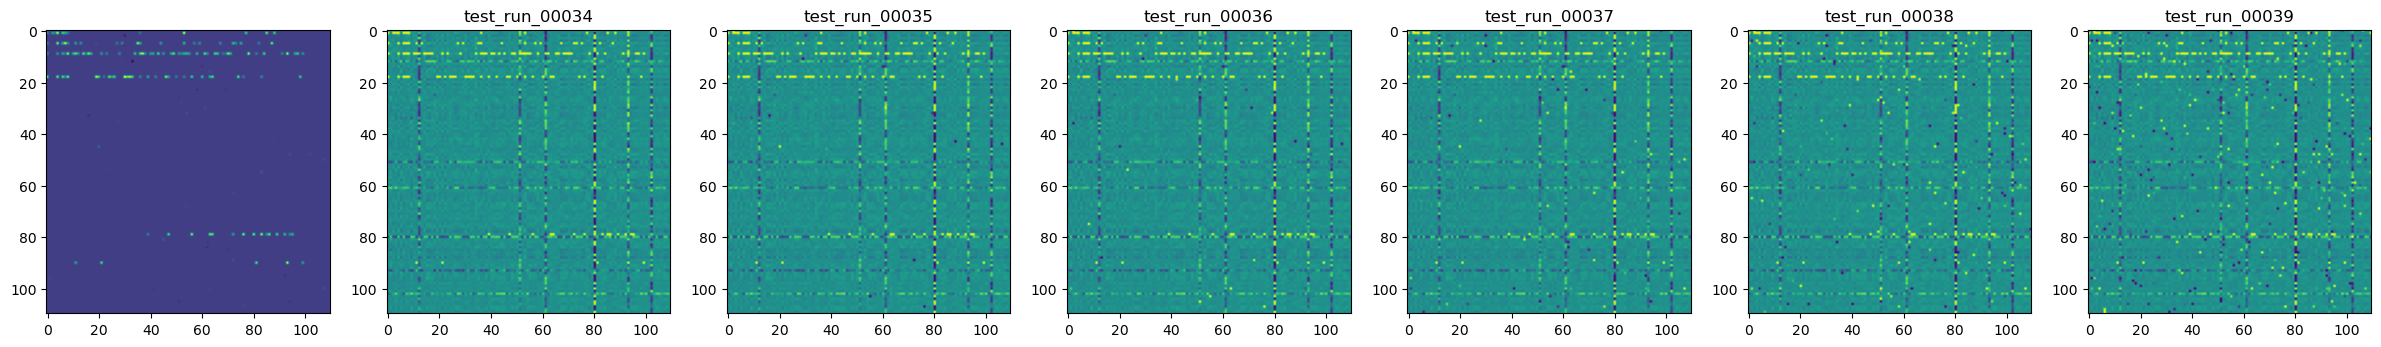

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=len(params)+1, figsize = (30, 20))
ax = ax.flatten()
ax[0].imshow(grn)
for n, run_id in enumerate(params.index):
    ax[n+1].imshow(ckpts[run_id]["beta"])
    ax[n+1].set_title(run_id)

test_run_00034
test_run_00035
test_run_00036
test_run_00037
test_run_00038
test_run_00039


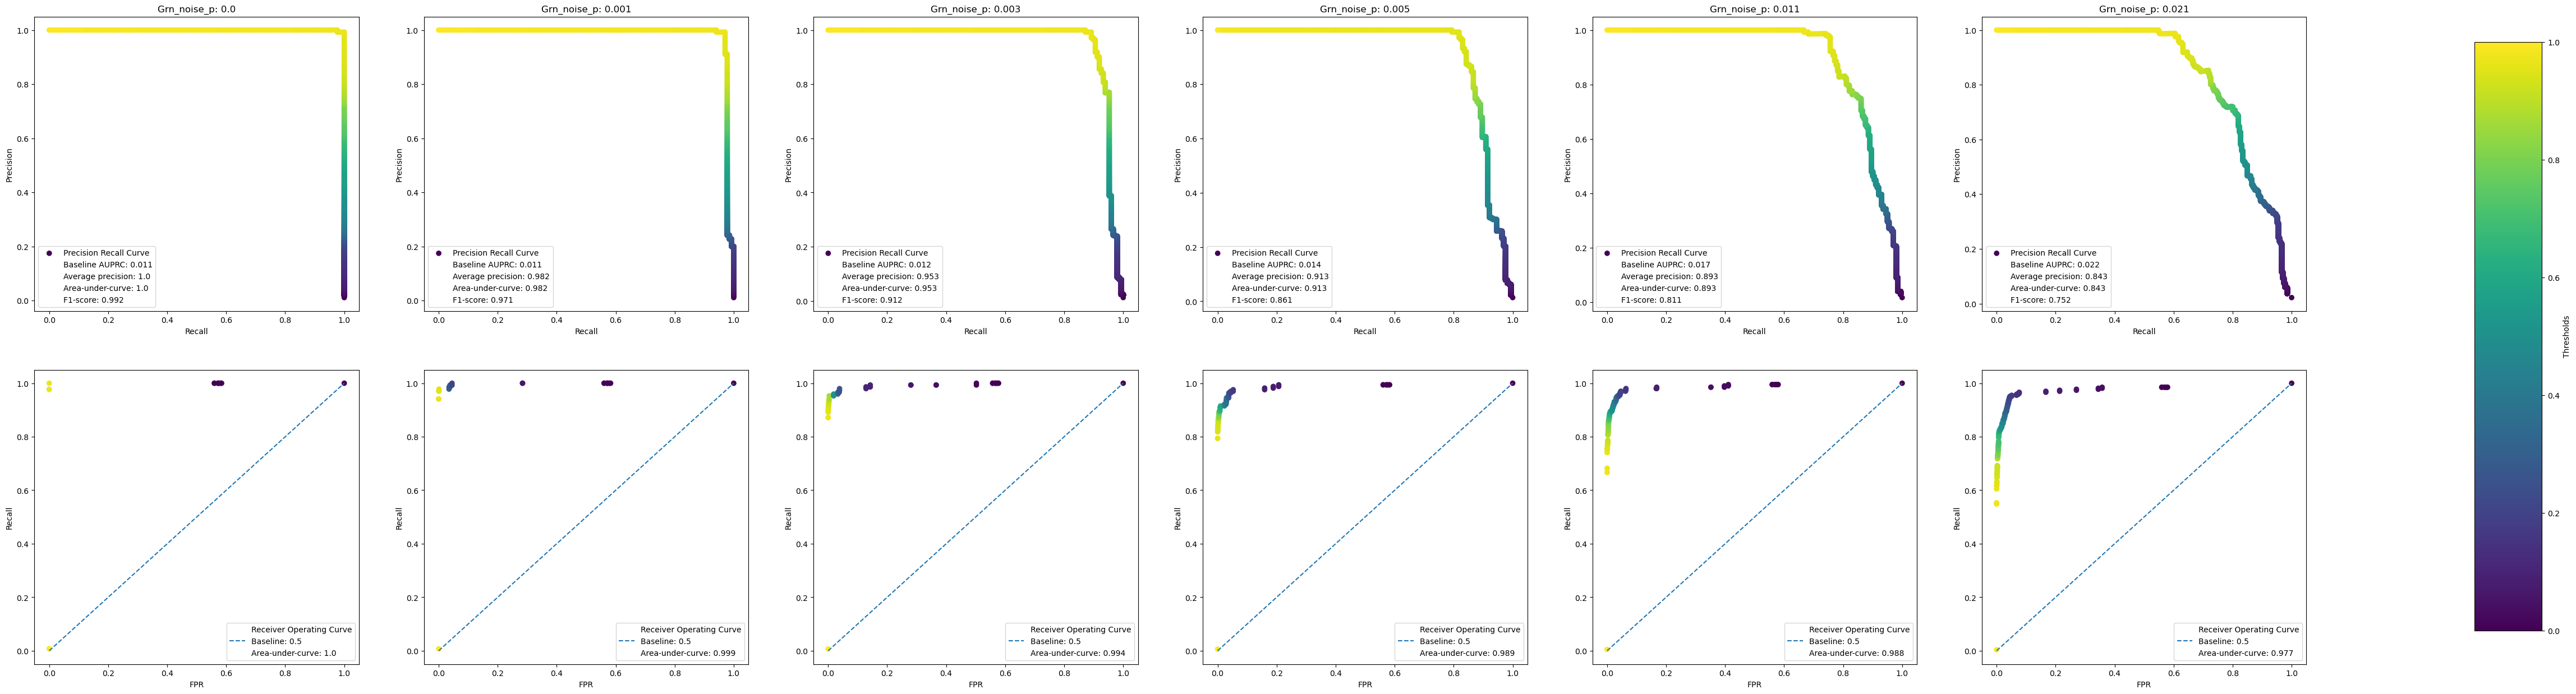

In [75]:
fig, ax=plt.subplots(nrows=2, ncols=len(ckpts.keys()), figsize=(len(ckpts.keys())*10, 15))
params["average_precision"] = np.empty(len(params))
params["auprc"] = np.empty(len(params))
params["f1"] = np.empty(len(params))
params["auroc"] = np.empty(len(params))
for n, run_id in enumerate(params.index):
    max_f1 = False

    print(run_id)
    beta = ckpts[run_id]["beta"]
    grn = ckpts[run_id]["grn"]
    # normalize to [0, 1]
    grn = (grn > 0).astype(int)
    beta[beta<0] = 0
    beta = beta/np.max(beta)
    grn=grn.flatten()
    beta=beta.flatten()
    precision, recall, prc_thresholds = precision_recall_curve(
        y_true=grn,
        y_score=beta,
        )
    # baseline is positive samples/total samples (saito et al.) = sparsity
    baseline_AUPRC = get_sparsity(grn)
    if max_f1:
        f1_scores = [f1_score(grn, above_threshold(beta, threshold=threshold)) for threshold in prc_thresholds]
        max_f1 = max(f1_scores)
    else:
        max_f1 = f1_score(grn, above_threshold(beta, percentile=100-baseline_AUPRC*100))
        
    auprc = auc(x=recall, y=precision)
    average_precision = average_precision_score(grn, beta)
    im = ax[0, n].scatter(recall,precision, label = "Precision Recall Curve", c = np.append(0, prc_thresholds), cmap = plt.colormaps["viridis"])
    ax[0, n].plot([], []," ",  label=f"Baseline AUPRC: {np.round(baseline_AUPRC, 3)}")
    ax[0, n].plot([], []," ",  label=f"Average precision: {np.round(average_precision, 3)}")
    ax[0, n].plot([], []," ",  label=f"Area-under-curve: {np.round(auprc, 3)}")
    ax[0, n].plot([], []," ",  label=f"F1-score: {np.round(max_f1, 3)}")
    
    ax[0, n].set_ylabel("Precision")
    ax[0, n].set_xlabel("Recall")
    ax[0, n].set_title(f"{param_of_interest.capitalize()}: {round(float(params.loc[run_id, param_of_interest]), 3)}")
    ax[0, n].legend()
    
    fpr, tpr, roc_thresholds=roc_curve(y_true=grn, y_score=beta)
    auroc = auc(fpr, tpr)
    ax[1, n].scatter(fpr,tpr, label = "Receiver Operating Curve", c =roc_thresholds, cmap = plt.colormaps["viridis"])
    ax[1, n].plot([0,1],[0,1],"--", label = "Baseline: 0.5")
    ax[1, n].plot([], []," ",  label=f"Area-under-curve: {np.round(auroc, 3)}")

    ax[1, n].set_ylabel("Recall")
    ax[1, n].set_xlabel("FPR")
    ax[1, n].legend()

    params.loc[run_id, "average_precision"] = average_precision
    params.loc[run_id, "auprc"] = auprc
    params.loc[run_id, "f1"] = max_f1
    params.loc[run_id, "auroc"] = auroc

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes((0.85, 0.15, 0.02, 0.7))
fig.colorbar(im, cax = cbar_ax, label="Thresholds")
fig.savefig(f"./presentation/{experiment}_metrics_curves.pdf")


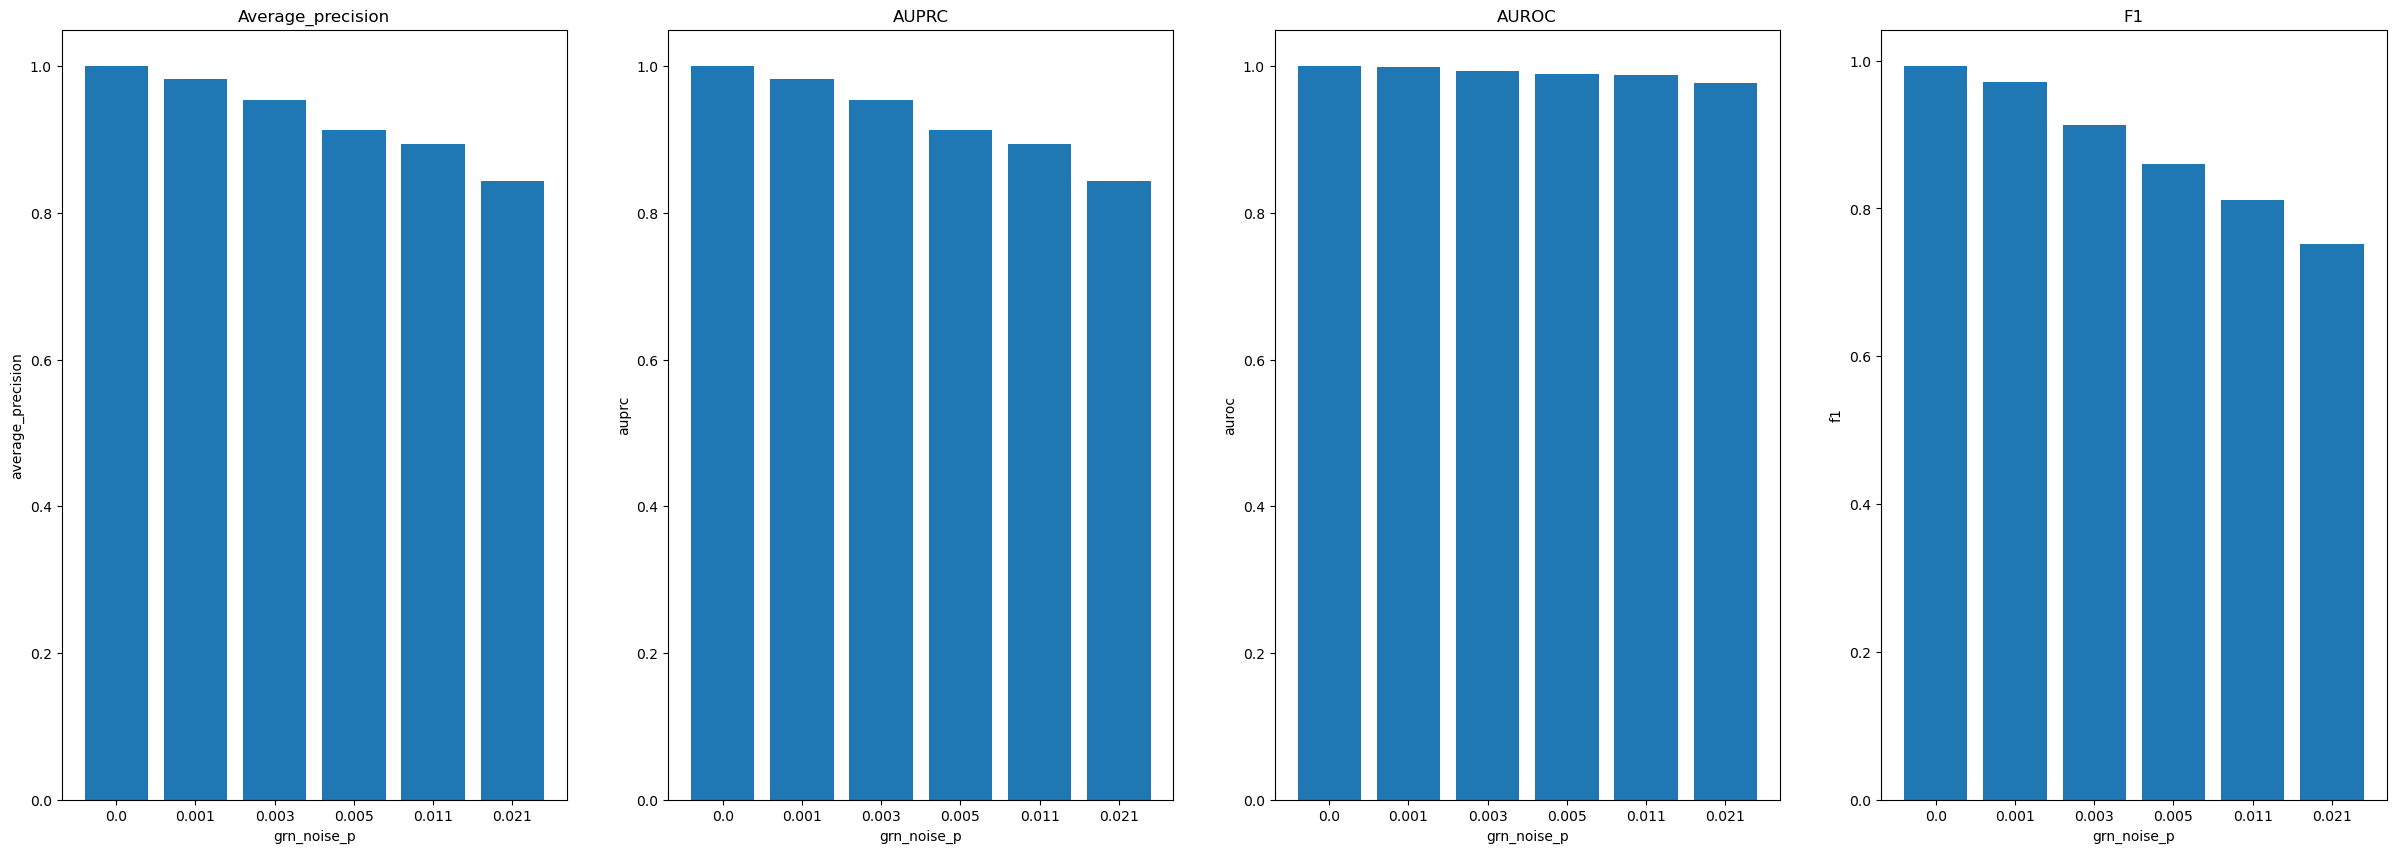

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
ax = ax.flatten()
for n, metric in enumerate(["average_precision","auprc","auroc", "f1"]):
    ax[n].bar(np.round(params[param_of_interest].astype(float), 3).astype(str), params[metric])
    if "_" in metric:
        ax[n].set_title(metric.capitalize())
    else:
        ax[n].set_title(metric.upper())
    ax[n].set_ylabel(metric)
    ax[n].set_xlabel(param_of_interest)
fig.savefig(f"./presentation/{experiment}_metrics_bar.pdf")

In [71]:
np.round(params[param_of_interest].astype(float), 3).astype(str)

test_run_00034      0.0
test_run_00035    0.001
test_run_00036    0.003
test_run_00037    0.005
test_run_00038    0.011
test_run_00039    0.021
Name: grn_noise_p, dtype: object